# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [380]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [381]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) == 0:
        return 0
    return 1/len(y) * np.sum(np.abs(y - y.mean()))

In [382]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [383]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    x_col = X[:, j]
    
    y_right = y[x_col >= t]
    y_left = y[x_col < t]
        
    return (y_left.size  * H(y_left) + y_right.size * H(y_right)) / y.size

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [384]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node 
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [385]:
# Code from semonar 7
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        
        
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None    
        
        # without splitting
        best_cost = H(y) 
        
        for split_column in range(X.shape[1]):
            
            x_col = X[:, split_column]
            
            for threshold in x_col:
                
                cost_function = Q(X, y, split_column, threshold)
                                
                if cost_function < best_cost:
                    best_split_column = split_column
                    best_threshold = threshold
                    best_cost = cost_function
            
        if best_split_column == None:
            return None, None, None, None, None, None
                    
        x_col = X[:, best_split_column]
        X_left = X[x_col < best_threshold, :]
        y_left = y[x_col < best_threshold]
        X_right = X[x_col >= best_threshold, :]
        y_right = y[x_col >= best_threshold]
                
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`, 
        `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False

        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal = True
            return
        if len(X) < self.min_samples_split:
            node.is_terminal = True
            return
        if len(np.unique(y)) == 1:
            node.is_terminal = True
            return
        
        
        # Make best split
        split_column, threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)
        
        # Check additional termination conditions
        if split_column is None:
            node.is_terminal = True
            return
        if len(X_left) < self.min_samples_leaf or len(X_right) < self.min_samples_leaf:  # min_samples_leaf check
            node.is_terminal = True
            return
        
        # Add split parameters into the current node
        node.column = split_column
        node.threshold = threshold

        # Create a left child of the current node
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)

        # Create a right child of the current node
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)

        # Make splits for the left and right nodes
        self.grow_tree(node.right, X_right, y_right)
        self.grow_tree(node.left, X_left, y_left)
        

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        
        # Initialize the tree (root node)
        self.tree_ = Node()                             
        self.tree_.depth = 0                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get 
            predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
            
        """
        # Termination condition
        if node.is_terminal == True:  
            return node.prediction  
        
        # Run to the current node's childs
        # Check split condition. If yes, go to the right child
        if x[node.column] < node.threshold:
            # Right child
            return self.get_prediction(node.left, x)
        else:
            # Left child
            return self.get_prediction(node.right, x)
            
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [386]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1, 3, 5** and make the following plots for every case:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model (tree visualization)

Compare `MAE` on train and test. Have trees overfitted?

In [387]:
# from sklearn.datasets import load_boston
import pickle


data = pickle.load(open('boston.pkl', 'rb'))
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

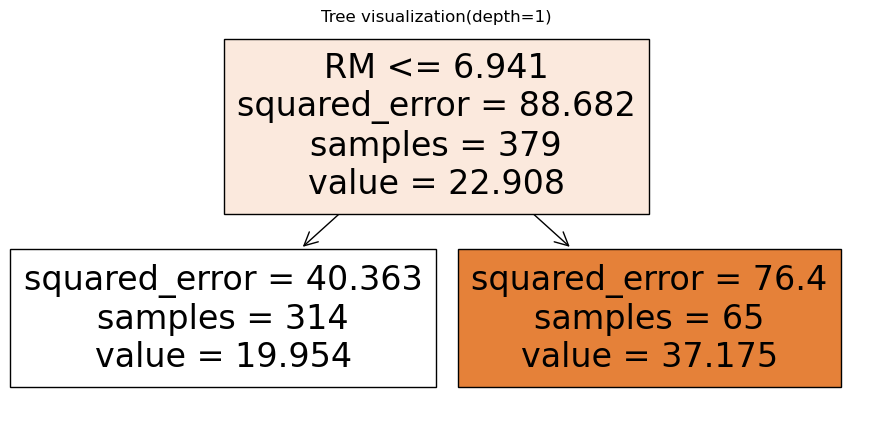

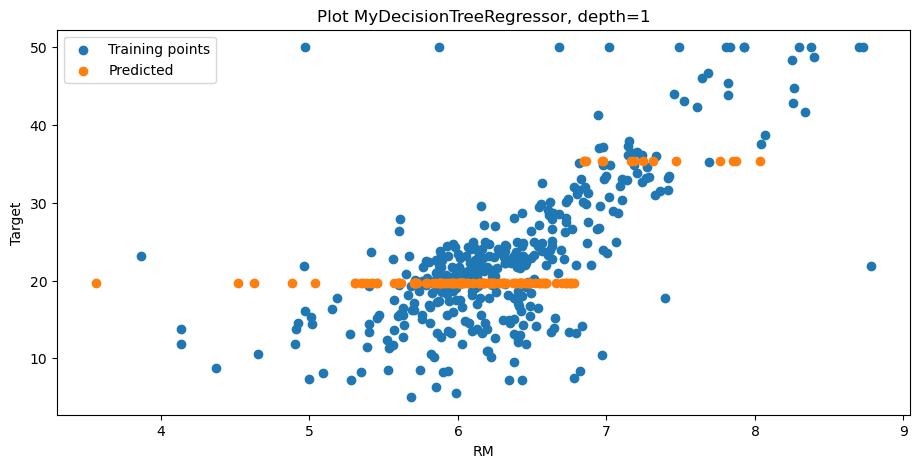

MAE for tree with depth=1:
MAE on Train: 5.045611391291763
MAE on Test: 4.8406561679790014
Is tree overfitted: tree is underfitted


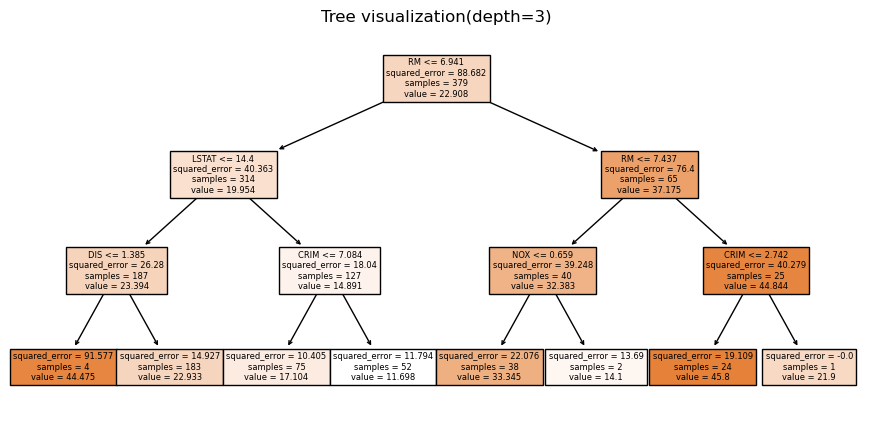

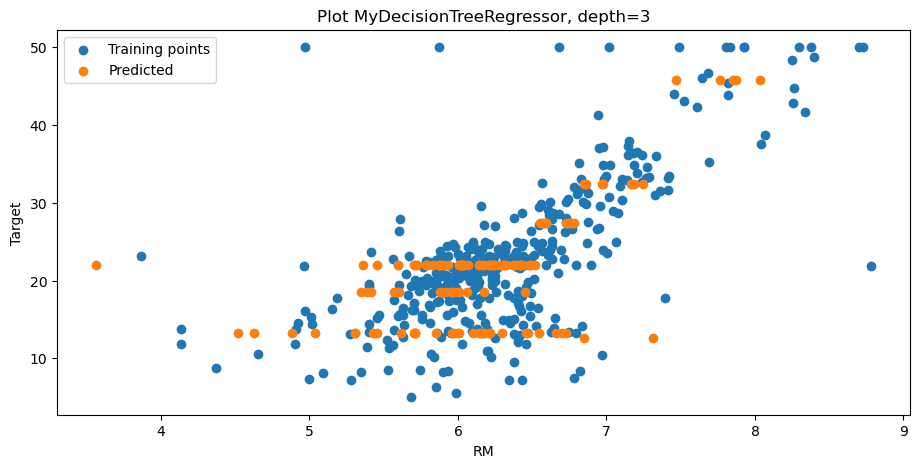

MAE for tree with depth=3:
MAE on Train: 2.797137933735398
MAE on Test: 3.1368721751649535
Is tree overfitted: no


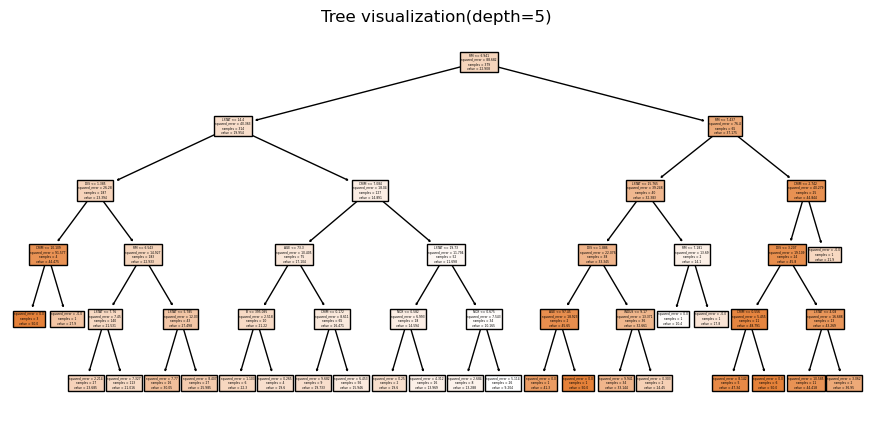

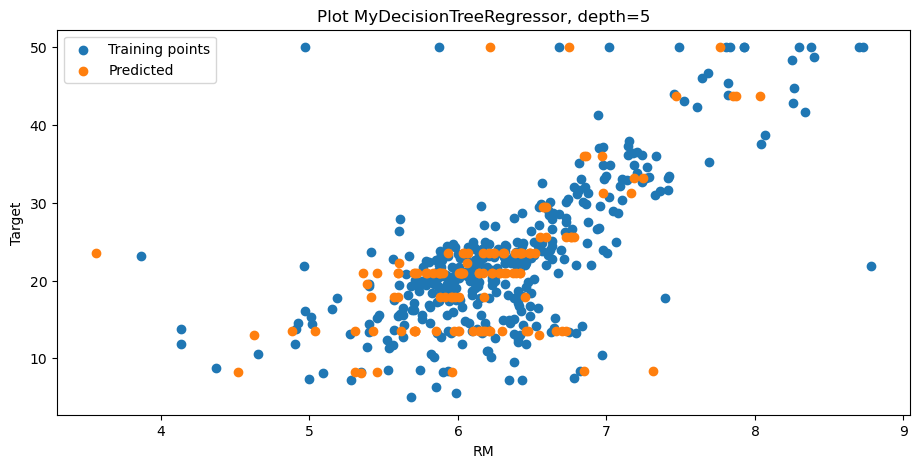

MAE for tree with depth=5:
MAE on Train: 1.907053687681929
MAE on Test: 2.954903022082632
Is tree overfitted: no


In [389]:
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

def plot_tree(hand_tree, sklrn_tree):
    y_pred_train = hand_tree.predict(X_train)
    y_pred_test = hand_tree.predict(X_test)
    
    column = hand_tree.tree_.column
    x_col_train = X_train.iloc[:, column]
    x_col_test = X_test.iloc[:, column]
    
    # Tree visualization
    tree.plot_tree(sklrn_tree, feature_names=data.feature_names.tolist(), filled=True)
    plt.title(f'Tree visualization(depth={hand_tree.max_depth})')
    plt.show()
      
    # Points visualization    
    plt.scatter(x_col_train, y_train, label="Training points")
    plt.scatter(x_col_test, y_pred_test, label="Predicted")
    
    plt.title(f'Plot MyDecisionTreeRegressor, depth={hand_tree.max_depth}')
    plt.xlabel(f'{data.feature_names[column]}')
    plt.ylabel('Target')
    plt.legend()
    plt.show()
    
    # MAE statistics
    print(f'MAE for tree with depth={hand_tree.max_depth}:')
    print(f'MAE on Train: {mean_absolute_error(y_train, y_pred_train)}')
    print(f'MAE on Test: {mean_absolute_error(y_test, y_pred_test)}')
    if mean_absolute_error(y_train, y_pred_train) > mean_absolute_error(y_test, y_pred_test):
        print(f'Is tree overfitted: tree is underfitted')
    else:
        print(f'Is tree overfitted: no')

max_depth = [1, 3, 5]

for depth in max_depth:
    hand_tree = MyDecisionTreeRegressor(max_depth = depth)
    sklrn_tree = DecisionTreeRegressor(max_depth = depth)
    hand_tree.fit(X_train, y_train)
    sklrn_tree.fit(X_train, y_train)
    plot_tree(hand_tree, sklrn_tree)

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

In [390]:
# Code from seminar 7

# Import GridSearchCV class
from sklearn.model_selection import GridSearchCV

clf = MyDecisionTreeRegressor()

# Estimate grid of the classifier hyperparameters
parameters = {'max_depth':[1, 3, 5, 7, 8, 9, 10], 'min_samples_leaf':[1, 3, 5, 7, 10, 25, 50]}

# Define GridSearch parameters
gs = GridSearchCV(clf,                 
                  parameters,          
                  scoring='neg_mean_absolute_error',  
                  cv=5)  

# Run Grid Search optimization
gs.fit(X_train, y_train)
gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 3}

In [391]:
pred = gs.predict(X_test)
print(f'Best MAE on test: {mean_absolute_error(y_test,pred)}')

Best MAE on test: 2.5692950859778696


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [392]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. 
    Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    
    sample_size = x.shape[0]
    
    # Result predict array
    y_pred = np.full((sample_size, n_iter), np.nan)
    
    for i in range(n_iter):
        # Get random indices for bootstrap
        mask = np.random.choice(sample_size, sample_size)
        
        # All the objects except bootstrap
        invertion = np.ones(sample_size, dtype=bool)
        invertion[mask] = False
                
        # Fit the model on bootstrap
        estimator.fit(x[mask, :], y[mask])
        
        # Predict all values except bootstrap
        y_pred[invertion, i] = estimator.predict(x[invertion, :])
      
    # Remove the preds that have all nans
    value_preds = y_pred[np.sum(~np.isnan(y_pred), axis=1) > 0]
            
    bias2 = np.nanmean((np.nanmean(value_preds, axis=1) - y[np.sum(~np.isnan(y_pred), axis=1) > 0])**2)
    variance = np.nanmean(np.nanvar(value_preds, axis=1))
    
    return bias2, variance

In [393]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train.values, y_train, 10)

(20.393745687737805, 8.795302490353897)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

In [395]:
# min_samples_split values
splits = np.array([1, 3, 5, 7, 15, 30, 50, 100, 150, 200])

# Get bias and variance for all splits values
bias_variance = np.array([get_bias_variance(MyDecisionTreeRegressor(max_depth=5, min_samples_split=split, min_samples_leaf=3), X_train.values, y_train, 10) for split in splits])

bias_variance

array([[21.52359391,  8.76708028],
       [21.06733185,  4.84476828],
       [22.57251137,  4.48623913],
       [22.52266384,  5.13546554],
       [20.62209526,  5.71642814],
       [24.25109292,  8.66025413],
       [20.38142662,  5.24058364],
       [34.16036038,  8.72019183],
       [32.72873711,  5.24774495],
       [35.3429813 ,  6.30226555]])

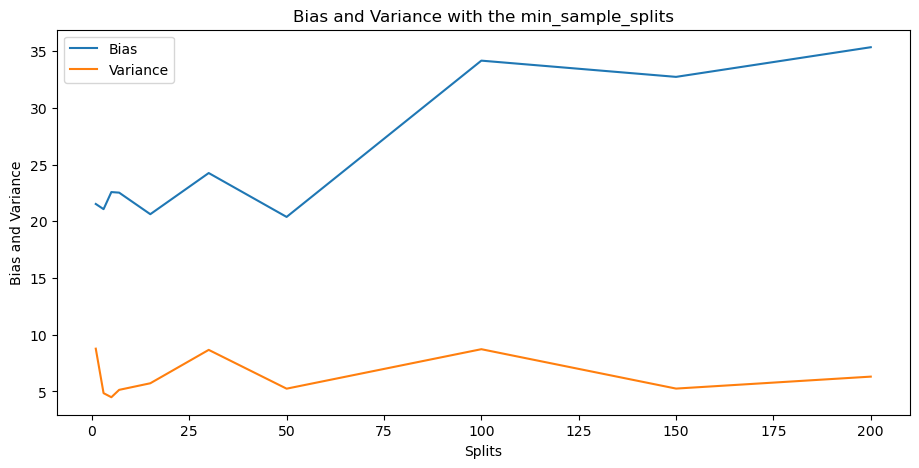

In [396]:
# Visualization
plt.plot(splits, bias_variance[:, 0], label='Bias')
plt.plot(splits, bias_variance[:, 1], label='Variance')

plt.title('Bias and Variance with the min_sample_splits')
plt.xlabel('Splits')
plt.ylabel('Bias and Variance')
plt.legend()
plt.show()

### Как можно видеть на графике, при увеличении min_sample_split bias увеличивается, в том время как varience уменьшается. В теории так и должно происходить с показателями, ведь чем больше min_sample_split, тем меньше глубина дерева и больше объектов в каждом узле, соответственно выше обобщающая способность, это приводит у увеличению смещения и уменьшению дисперсии.

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [398]:
from sklearn.ensemble import BaggingRegressor

bag = BaggingRegressor(MyDecisionTreeRegressor(max_depth=5, min_samples_split=15, min_samples_leaf=3), random_state=42)
get_bias_variance(bag, X_train.values, y_train, 10)

(18.96694787350713, 1.8056466259688684)

### Bagging в теории помогает снизить смещение и уменьшать дисперсию с помощью усреднения предсказаний нескольких моделей и, судя по нашим показателям, это и случилось, смещение и дисперсия действительно уменьшились. Bagging улучшил нашу ситуацию, потому что в нашей выборке нет большого количества выбросов, а также у нас изначально была небольшая дисперсия, при таких условиях BaggingRegressor ничем бы нам не помог.

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task. 

In [399]:
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector

df = pd.read_csv('Billionaires Statistics Dataset.csv')

le = LabelEncoder()
y = le.fit_transform(df['selfMade'])
X = df.drop('selfMade', axis=1)
X.head(5)

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are many unique values in a column, you can group them by meaning)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

#### Для начала исключим ненужные столбцы, имеющие слишком много пропусков

In [402]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rank                                        2640 non-null   int64  
 1   finalWorth                                  2640 non-null   int64  
 2   category                                    2640 non-null   object 
 3   personName                                  2640 non-null   object 
 4   age                                         2575 non-null   float64
 5   country                                     2602 non-null   object 
 6   city                                        2568 non-null   object 
 7   source                                      2640 non-null   object 
 8   industries                                  2640 non-null   object 
 9   countryOfCitizenship                        2640 non-null   object 
 10  organization

In [403]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


print(X.isna().sum())
print(f'X shape = {X.shape}')

rank                                             0
finalWorth                                       0
category                                         0
personName                                       0
age                                             65
country                                         38
city                                            72
source                                           0
industries                                       0
countryOfCitizenship                             0
organization                                  2315
status                                           0
gender                                           0
birthDate                                       76
lastName                                         0
firstName                                        3
title                                         2301
date                                             0
state                                         1887
residenceStateRegion           

#### Столбцы organization, title, state, residenceStateRegion имеют слишком большое количество пропусков, поэтому при предсказании они нам ничем не помогут

In [404]:
X = X.drop(['organization', 'title', 'state', 'residenceStateRegion'], axis=1)

#### Также нам не подойдут столбцы, имеющие большое количество уникальных значений, это никак не улучшить предсказание

In [405]:
X.apply(pd.Series.nunique)

rank                                           219
finalWorth                                     219
category                                        18
personName                                    2638
age                                             79
country                                         78
city                                           741
source                                         906
industries                                      18
countryOfCitizenship                            77
status                                           6
gender                                           2
birthDate                                     2060
lastName                                      1736
firstName                                     1770
date                                             2
birthYear                                       77
birthMonth                                      12
birthDay                                        31
cpi_country                    

#### Столбцы personName, birthDate, lastName, firstName, city, source можно исключить

In [406]:
X = X.drop(['personName', 'birthDate', 'lastName', 'firstName', 'city', 'source'], axis=1)

In [407]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 24 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rank                                        2640 non-null   int64  
 1   finalWorth                                  2640 non-null   int64  
 2   category                                    2640 non-null   object 
 3   age                                         2575 non-null   float64
 4   country                                     2602 non-null   object 
 5   industries                                  2640 non-null   object 
 6   countryOfCitizenship                        2640 non-null   object 
 7   status                                      2640 non-null   object 
 8   gender                                      2640 non-null   object 
 9   date                                        2640 non-null   object 
 10  birthYear   

In [408]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [409]:
# Define pipeline
pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first'))

# Define column transformer
column_transformer = ColumnTransformer([
    ('numeric', SimpleImputer(missing_values=np.nan, strategy='mean'), make_column_selector(dtype_include=[float, int])),
    ('categoric', pipeline, make_column_selector(dtype_include=object))], remainder='passthrough')

In [410]:
# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

ValueError: Found unknown categories ['Colombia', 'Bahrain', 'Lebanon', 'British Virgin Islands'] in column 1 during transform

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

In [ ]:
# YOUR CODE HERE